# Data Analysis

## Primeras aproximaciones de análisis

In [132]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from datetime import date

pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")

# Cargamos el dataframe final de extracción, donde están todas las canciones, con duplicados (los hemos dejado
# por si utilizamos en algún momento la columna position)
data_ana = pd.read_csv("data_global.csv", sep = ',')
print(data_ana.shape)

# Quitamos las columnas que no usaremos casi seguro
data_ana= data_ana.drop(columns=['Unnamed: 0', 'Position'])
print(data_ana.shape)

# Quitamos los duplicados por canciones, no nos sirven de momento para el análisis principal.
data_ana = data_ana.drop_duplicates(subset='spotify_id').copy()
print(data_ana.shape)

#Revisamos los tipos de datos:
print(data_ana.info())

(48059, 37)
(48059, 35)
(1590, 35)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 48058
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Track Name         1590 non-null   object 
 1   Artist             1590 non-null   object 
 2   Streams            1590 non-null   int64  
 3   date               1590 non-null   object 
 4   spotify_id         1590 non-null   object 
 5   year               1590 non-null   int64  
 6   Streamstotal       1590 non-null   int64  
 7   album              1590 non-null   object 
 8   release_date       1590 non-null   object 
 9   length             1590 non-null   float64
 10  popularity         1590 non-null   float64
 11  acousticness       1590 non-null   float64
 12  danceability       1590 non-null   float64
 13  energy             1590 non-null   float64
 14  instrumentalness   1590 non-null   float64
 15  liveness           1590 non-null   f

/Users/victormac/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## PREVIO: Hacer ponderación para calcular medias respecto a los streams totales

- Añadir una columna con el peso respecto a Streams total, y respecto a su año
- Luego habría que multiplicar el valor de cada feature por el peso y sumar los resultados.

In [133]:
data_ana.head(3)

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity
0,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,2019-11-07,0.324972,0.91,0.295,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,7027186,Follow,2020-04-01,0.330442,0.78,0.667,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
103,Créeme,KAROL G,72543,2019-03-14,1mT47pKLXUwPYGwB91GcNz,2019,3197262,Créeme,2018-11-02,0.354546,0.72,0.154,0.715,0.872,0.000146,0.1100,0.904169,0.045599,0.682,0.230459,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755


In [134]:
# Ojo, puede ocurrir que una misma canción de un artista se repita, porque está en el top200 dos años diferentes y albunes diferentes
data_ana[data_ana['Artist'] == 'KAROL G']

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity
0,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,2019-11-07,0.324972,0.91,0.29500,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,7027186,Follow,2020-04-01,0.330442,0.78,0.66700,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
103,Créeme,KAROL G,72543,2019-03-14,1mT47pKLXUwPYGwB91GcNz,2019,3197262,Créeme,2018-11-02,0.354546,0.72,0.15400,0.715,0.872,0.000146,0.1100,0.904169,0.045599,0.682,0.230459,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
153,Culpables,KAROL G,56296,2019-03-14,6q8Lb50EtqNeeJXXe8mMAH,2019,2080234,Culpables,2018-09-14,0.390787,0.69,0.27900,0.728,0.801,0.000005,0.1430,0.922521,0.065287,0.416,0.451744,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
203,Punto G,KAROL G,51826,2019-04-05,5Lb1pjnll07UQKxNpnnGBy,2019,1930173,Punto G,2019-04-05,0.275291,0.61,0.00796,0.787,0.751,0.000139,0.0857,0.863559,0.091633,0.926,0.691617,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
231,Punto G,KAROL G,122406,2019-05-03,2E82gORVSA7UMEz5M1IP3b,2019,1249207,OCEAN,2019-05-03,0.279327,0.62,0.00938,0.791,0.746,0.000117,0.1250,0.864281,0.097713,0.905,0.691837,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
242,Créeme,KAROL G,64151,2019-05-03,4EKZsrsCKyqr64FBHLc0DU,2019,661661,OCEAN,2019-05-03,0.359162,0.66,0.12600,0.715,0.874,0.000162,0.1050,0.901707,0.045744,0.652,0.230833,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
253,Love With A Quality,KAROL G,46140,2019-05-03,6F9DPkjP6Tbz9FLgLyYgX6,2019,46140,OCEAN,2019-05-03,0.383438,0.61,0.06460,0.849,0.752,0.000003,0.1060,0.895798,0.177765,0.586,0.257712,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
254,Culpables,KAROL G,41255,2019-05-03,4RGKft6YTTWHjpQeRIInuS,2019,396519,OCEAN,2019-05-03,0.396773,0.60,0.28700,0.728,0.812,0.000003,0.1300,0.920059,0.087001,0.418,0.451544,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755
265,Ocean,KAROL G,31994,2019-05-03,6qoIFQfdmaQF9A1gb67tR7,2019,643265,OCEAN,2019-05-03,0.209542,0.74,0.93300,0.727,0.482,0.000000,0.3880,0.815791,0.132889,0.487,0.083410,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755


In [135]:
# Vemos que en el 2018 hay muchos menos Streams totales, eso puede significar que se usaba menos Spotify, o 
# que el top200 no se escuchaba tanto.
data_ana.groupby(['year']).sum()

,Streams,Streamstotal,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,artist_followers,artist_popularity
year,,,,,,,,,,,,,,,,
2017,12902458,424471115,143.359467,145.54,79.971451,264.977,270.8601,2.607547,66.2281,321.661983,38.393602,225.9088,147.358787,1543,4655362349,312.061224
2018,17597794,703032487,141.906328,156.82,93.871540,284.207,279.6534,2.373905,67.6059,343.049705,46.065576,222.2379,162.616031,1640,3669099960,327.459184
2019,23770926,932060402,132.957076,215.56,100.759445,264.008,249.0571,5.288190,63.1994,309.835259,54.750869,212.7080,154.502201,1489,3359492613,302.775510
2020,34820012,1122925513,139.772387,300.68,100.400680,298.778,282.9094,3.191402,65.4450,349.876428,58.711783,248.5395,171.267961,1659,3037289338,340.489796


In [136]:
data_ana.groupby(['year']).count()

,Track Name,Artist,Streams,date,spotify_id,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,383,348,277,220,175,95,46,21,7,1,383,387,387,387
2018,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,410,370,317,211,129,56,23,8,5,1,410,412,412,412
2019,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,328,257,164,103,51,32,6,2,0,374,374,374,374
2020,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,409,330,253,104,61,24,8,2,0,0,409,417,417,417


In [137]:
# Vamos a añadir los pesos de cada canción en una nueva columna
# Versión optimizada corta y sin warnings

data_ana_2020 = data_ana.loc[data_ana['year'] == 2020]
data_ana_2019 = data_ana.loc[data_ana['year'] == 2019]
data_ana_2018 = data_ana.loc[data_ana['year'] == 2018]
data_ana_2017 = data_ana.loc[data_ana['year'] == 2017]

data_ana.loc[data_ana.year == 2020, 'streamstotal_weights'] = data_ana_2020['Streamstotal']/data_ana_2020['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2019, 'streamstotal_weights'] = data_ana_2019['Streamstotal']/data_ana_2019['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2018, 'streamstotal_weights'] = data_ana_2018['Streamstotal']/data_ana_2018['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2017, 'streamstotal_weights'] = data_ana_2017['Streamstotal']/data_ana_2017['Streamstotal'].sum()


In [138]:
data_ana.head()

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights
0,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,2019-11-07,0.324972,0.91,0.29500,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.016786
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,7027186,Follow,2020-04-01,0.330442,0.78,0.66700,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.006258
103,Créeme,KAROL G,72543,2019-03-14,1mT47pKLXUwPYGwB91GcNz,2019,3197262,Créeme,2018-11-02,0.354546,0.72,0.15400,0.715,0.872,0.000146,0.1100,0.904169,0.045599,0.682,0.230459,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.003430
153,Culpables,KAROL G,56296,2019-03-14,6q8Lb50EtqNeeJXXe8mMAH,2019,2080234,Culpables,2018-09-14,0.390787,0.69,0.27900,0.728,0.801,0.000005,0.1430,0.922521,0.065287,0.416,0.451744,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.002232
203,Punto G,KAROL G,51826,2019-04-05,5Lb1pjnll07UQKxNpnnGBy,2019,1930173,Punto G,2019-04-05,0.275291,0.61,0.00796,0.787,0.751,0.000139,0.0857,0.863559,0.091633,0.926,0.691617,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.002071


In [139]:
'''# Forma rudimentaria de hacerlo, probar a hacerlo con un apply y lambda https://thispointer.com/pandas-apply-a-function-to-single-or-selected-columns-or-rows-in-dataframe/

data_ana_2020 = data_ana.loc[data_ana['year'] == 2020]
data_ana_2019 = data_ana.loc[data_ana['year'] == 2019]
data_ana_2018 = data_ana.loc[data_ana['year'] == 2018]

total_streams_2020 = data_ana_2020['Streamstotal'].sum()
print(total_streams_2018)
total_streams_2019 = data_ana_2019['Streamstotal'].sum()
print(total_streams_2019)
total_streams_2018 = data_ana_2018['Streamstotal'].sum()
print(total_streams_2020)

data_ana_2020['streamstotal_weights'] = data_ana_2020['Streamstotal']/total_streams_2020
data_ana_2019['streamstotal_weights'] = data_ana_2019['Streamstotal']/total_streams_2019

data_ana_2020_only = data_ana_2020[['year','spotify_id', 'streamstotal_weights']].copy()
data_ana_2019_only = data_ana_2019[['year','spotify_id', 'streamstotal_weights']].copy()
data_ana_sum = pd.concat([data_ana_2020_only, data_ana_2019_only], axis=0)

data_anam = pd.merge(data_ana, data_ana_sum, on=['year','spotify_id'])
data_anam.head()'''

"# Forma rudimentaria de hacerlo, probar a hacerlo con un apply y lambda https://thispointer.com/pandas-apply-a-function-to-single-or-selected-columns-or-rows-in-dataframe/\n\ndata_ana_2020 = data_ana.loc[data_ana['year'] == 2020]\ndata_ana_2019 = data_ana.loc[data_ana['year'] == 2019]\ndata_ana_2018 = data_ana.loc[data_ana['year'] == 2018]\n\ntotal_streams_2020 = data_ana_2020['Streamstotal'].sum()\nprint(total_streams_2018)\ntotal_streams_2019 = data_ana_2019['Streamstotal'].sum()\nprint(total_streams_2019)\ntotal_streams_2018 = data_ana_2018['Streamstotal'].sum()\nprint(total_streams_2020)\n\ndata_ana_2020['streamstotal_weights'] = data_ana_2020['Streamstotal']/total_streams_2020\ndata_ana_2019['streamstotal_weights'] = data_ana_2019['Streamstotal']/total_streams_2019\n\ndata_ana_2020_only = data_ana_2020[['year','spotify_id', 'streamstotal_weights']].copy()\ndata_ana_2019_only = data_ana_2019[['year','spotify_id', 'streamstotal_weights']].copy()\ndata_ana_sum = pd.concat([data_ana_

In [140]:
# Comprobaciones
print(data_ana.shape)

# Deberían sumar 1 los pesos de cada año
print(data_ana.loc[data_ana['year'] == 2020, 'streamstotal_weights'].sum())
print(data_ana.loc[data_ana['year'] == 2019, 'streamstotal_weights'].sum())
print(data_ana.loc[data_ana['year'] == 2018, 'streamstotal_weights'].sum())
print(data_ana.loc[data_ana['year'] == 2017, 'streamstotal_weights'].sum())

#Ver cómo sale
data_ana[data_ana['Track Name'] == 'Punto G']

(1590, 36)
1.0
1.0
1.0
1.0


,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights
203,Punto G,KAROL G,51826,2019-04-05,5Lb1pjnll07UQKxNpnnGBy,2019,1930173,Punto G,2019-04-05,0.275291,0.61,0.00796,0.787,0.751,0.000139,0.0857,0.863559,0.091633,0.926,0.691617,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.002071
231,Punto G,KAROL G,122406,2019-05-03,2E82gORVSA7UMEz5M1IP3b,2019,1249207,OCEAN,2019-05-03,0.279327,0.62,0.00938,0.791,0.746,0.000117,0.1250,0.864281,0.097713,0.905,0.691837,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.001340


# Análisis

In [141]:
# Vemos que el número de canciones únicas en cada año registradas
data_ana.groupby(['year']).count()

,Track Name,Artist,Streams,date,spotify_id,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,383,348,277,220,175,95,46,21,7,1,383,387,387,387,387
2018,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,410,370,317,211,129,56,23,8,5,1,410,412,412,412,412
2019,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,328,257,164,103,51,32,6,2,0,374,374,374,374,374
2020,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,409,330,253,104,61,24,8,2,0,0,409,417,417,417,417


## ¿Ha cambiado la cantidad de música que se escucha en spotify?

- A partir de streams totales de cada año

In [142]:
data_ana.groupby(['year']).sum()

,Streams,Streamstotal,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,
2017,12902458,424471115,143.359467,145.54,79.971451,264.977,270.8601,2.607547,66.2281,321.661983,38.393602,225.9088,147.358787,1543,4655362349,312.061224,1.0
2018,17597794,703032487,141.906328,156.82,93.871540,284.207,279.6534,2.373905,67.6059,343.049705,46.065576,222.2379,162.616031,1640,3669099960,327.459184,1.0
2019,23770926,932060402,132.957076,215.56,100.759445,264.008,249.0571,5.288190,63.1994,309.835259,54.750869,212.7080,154.502201,1489,3359492613,302.775510,1.0
2020,34820012,1122925513,139.772387,300.68,100.400680,298.778,282.9094,3.191402,65.4450,349.876428,58.711783,248.5395,171.267961,1659,3037289338,340.489796,1.0


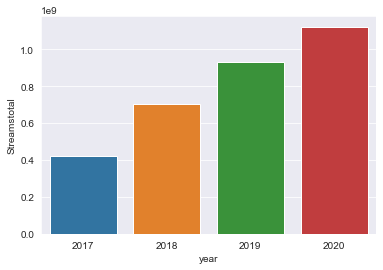

In [143]:
data_ana_streams = data_ana.loc[:, ['year', 'Streamstotal']]
data_year_streams = data_ana_streams.groupby(['year']).sum()
data_year_streams.reset_index(inplace=True)
data_year_streams

sns.barplot(x="year", y="Streamstotal", data=data_year_streams)

#### **Análisis**: Vemos que los streams total de cada año varian, siendo las del 2020 casi el doble. Cuidado porque puede ocurrir que spotify lo escuchaba menos gente, que la gente escichaba más variedad (hay que acordarse que los datos son del top200, toda la música que no esté en el top200 se queda fuera

## ¿Ha cambiado la antiguedad de la música que se escucha?, ¿hemos esuchado más clasicos?

- Poner en columna año.
- Ver distribución de años.
- Nueva columna con rangos de años.

## ¿Han cambiado las features?

### >>>Pruebas

In [144]:
# Vemos una aproximación de las medias sin ponderar de las features, a ver si tienen sentido, parece que si, y todas están entre 0 y 1
data_ana.groupby(['year']).mean()


,Streams,Streamstotal,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,
2017,33339.684755,1.096825e+06,0.370438,0.376072,0.206645,0.684695,0.699897,0.006738,0.171132,0.831168,0.099208,0.583744,0.380772,3.987080,1.202936e+07,0.806360,0.002584
2018,42713.092233,1.706390e+06,0.344433,0.380631,0.227844,0.689823,0.678770,0.005762,0.164092,0.832645,0.111810,0.539412,0.394699,3.980583,8.905582e+06,0.794804,0.002427
2019,63558.625668,2.492140e+06,0.355500,0.576364,0.269410,0.705904,0.665928,0.014140,0.168982,0.828437,0.146393,0.568738,0.413107,3.981283,8.982601e+06,0.809560,0.002674
2020,83501.227818,2.692867e+06,0.335186,0.721055,0.240769,0.716494,0.678440,0.007653,0.156942,0.839032,0.140796,0.596018,0.410715,3.978417,7.283667e+06,0.816522,0.002398


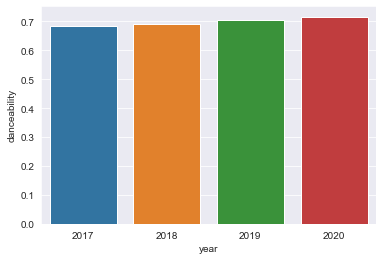

In [145]:
# Ploteamos la media de una feature concreta (sin ponderar)
data_year_means= data_ana.groupby(['year']).mean()
data_year_means.reset_index(inplace=True)
data_year_means

sns.barplot(x="year", y="danceability", data=data_year_means)

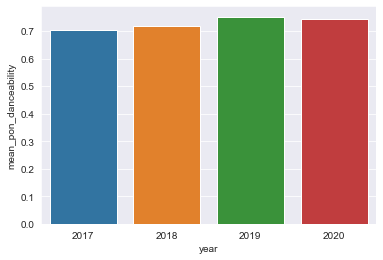

In [146]:
# Función para calcular las medias ponderadas de cada feature por años, para poner en gráficos fácilmente.
def mediapon_features (feature):
    data_dance_compar = data_ana.loc[:, ['year', feature, 'streamstotal_weights']]
    data_dance_compar["mean_pon_" + feature] = data_dance_compar[feature] * data_dance_compar['streamstotal_weights']
    media_dance_compar = data_dance_compar.groupby(['year']).sum()
    media_dance_compar.reset_index(inplace=True)
    media_dance_compar = media_dance_compar.drop(columns=[feature])
    return media_dance_compar

#Prueba
media_dance_pon = mediapon_features ('danceability')
sns.barplot(x="year", y="mean_pon_danceability", data=media_dance_pon)

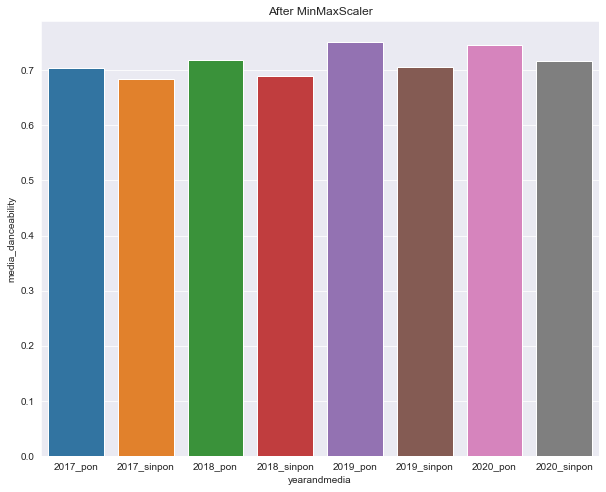

In [147]:
# Comparar medias sin y con ponderación
comparar_pon_ysinpon = pd.merge(data_year_means, media_dance_pon, how='right', on="year")
comparar_pon_ysinpon = comparar_pon_ysinpon[['year', 'danceability', 'mean_pon_danceability']]

#Hago un melt de la tabla porque quiero comparar
comparar_pon_ysinpon2 = pd.melt(comparar_pon_ysinpon,
        id_vars = ['year'],
       value_vars = ['danceability', "mean_pon_danceability"],
       value_name = 'media_danceability')

list_x = ['2017_sinpon', '2018_sinpon', '2019_sinpon', '2020_sinpon', '2017_pon', '2018_pon', '2019_pon', '2020_pon']
comparar_pon_ysinpon2['yearandmedia'] = list_x
comparar_pon_ysinpon2 =  comparar_pon_ysinpon2.drop(columns=['variable', 'year'])
comparar_pon_ysinpon2 = comparar_pon_ysinpon2.sort_values('yearandmedia')

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After MinMaxScaler')
sns.barplot(x="yearandmedia", y ='media_danceability', data=comparar_pon_ysinpon2)

# Hay una diferencia, se ve que en general aumentan los valores.

In [148]:
data_ana.columns

Index(['Track Name', 'Artist', 'Streams', 'date', 'spotify_id', 'year',
       'Streamstotal', 'album', 'release_date', 'length', 'popularity',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
       'time_signature', 'genre1', 'genre2', 'genre3', 'genre4', 'genre5',
       'genre6', 'genre7', 'genre8', 'genre9', 'genre10', 'genres_together',
       'artist_id', 'artist_followers', 'artist_popularity',
       'streamstotal_weights'],
      dtype='object')

### >>> length

**Features:**
'length'
'popularity'
'acousticness'
'danceability'
'energy'
'instrumentalness'
'liveness'
'loudness'
'speechiness'
'valence'
'tempo'

,year,streamstotal_weights,mean_pon_length
0,2017,1.0,0.376400
1,2018,1.0,0.356756
2,2019,1.0,0.373912
3,2020,1.0,0.335106


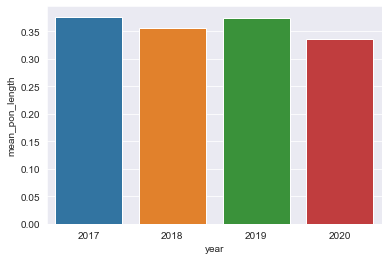

In [149]:
media_length = mediapon_features ('length')
sns.barplot(x="year", y="mean_pon_length", data=media_length)
media_length

### >>> Popularity

,year,streamstotal_weights,mean_pon_popularity
0,2017,1.0,0.369609
1,2018,1.0,0.367623
2,2019,1.0,0.588037
3,2020,1.0,0.771828


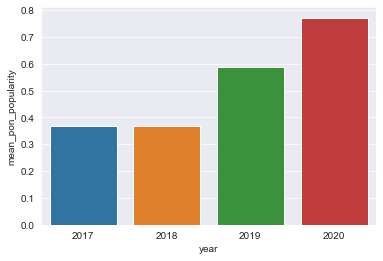

In [150]:
media_popularity = mediapon_features ('popularity')
sns.barplot(x="year", y="mean_pon_popularity", data=media_popularity)
media_popularity

### >>> acousticness

,year,streamstotal_weights,mean_pon_acousticness
0,2017,1.0,0.173837
1,2018,1.0,0.198447
2,2019,1.0,0.276493
3,2020,1.0,0.218525


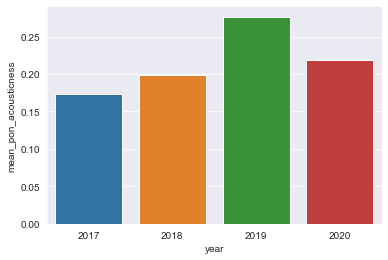

In [151]:
media_acousticness = mediapon_features ('acousticness')
sns.barplot(x="year", y="mean_pon_acousticness", data=media_acousticness)
media_acousticness

### >>> danceability

,year,streamstotal_weights,mean_pon_danceability
0,2017,1.0,0.704916
1,2018,1.0,0.718892
2,2019,1.0,0.752050
3,2020,1.0,0.745392


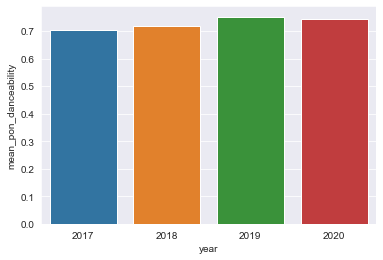

In [152]:
media_danceability = mediapon_features ('danceability')
sns.barplot(x="year", y="mean_pon_danceability", data=media_danceability)
media_danceability

### >>> energy

,year,streamstotal_weights,mean_pon_energy
0,2017,1.0,0.748913
1,2018,1.0,0.719493
2,2019,1.0,0.685468
3,2020,1.0,0.703327


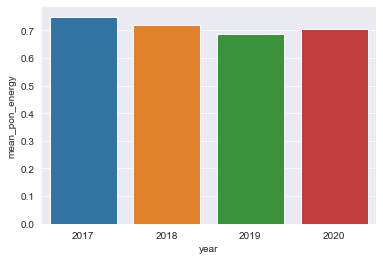

In [153]:
media_energy = mediapon_features ('energy')
sns.barplot(x="year", y="mean_pon_energy", data=media_energy)
media_energy

### >>> instrumentalness

,year,streamstotal_weights,mean_pon_instrumentalness
0,2017,1.0,0.001845
1,2018,1.0,0.001609
2,2019,1.0,0.002610
3,2020,1.0,0.007286


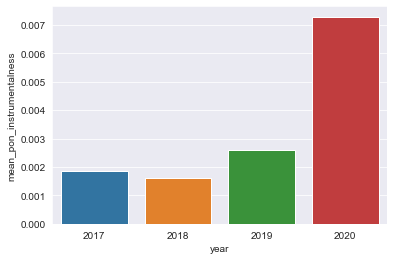

In [154]:
# Se ve un aumento, pero no es significativo, de 0,5 a 0 se considera no instrumental
media_instrumentalness = mediapon_features ('instrumentalness')
sns.barplot(x="year", y="mean_pon_instrumentalness", data=media_instrumentalness)
media_instrumentalness

### >>> liveness

,year,streamstotal_weights,mean_pon_liveness
0,2017,1.0,0.159971
1,2018,1.0,0.189007
2,2019,1.0,0.155698
3,2020,1.0,0.149722


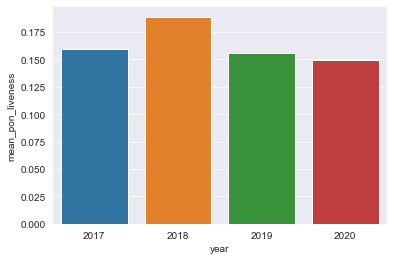

In [155]:
media_liveness = mediapon_features ('liveness')
sns.barplot(x="year", y="mean_pon_liveness", data=media_liveness)
media_liveness

### >>> loudness

,year,streamstotal_weights,mean_pon_loudness
0,2017,1.0,0.857414
1,2018,1.0,0.852523
2,2019,1.0,0.850310
3,2020,1.0,0.855269


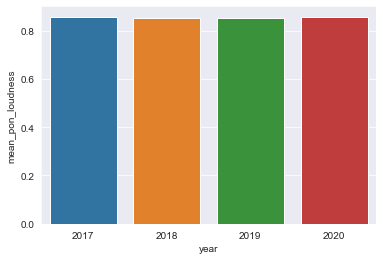

In [156]:
media_loudness = mediapon_features ('loudness')
sns.barplot(x="year", y="mean_pon_loudness", data=media_loudness)
media_loudness

### >>> speechiness

,year,streamstotal_weights,mean_pon_speechiness
0,2017,1.0,0.111891
1,2018,1.0,0.098769
2,2019,1.0,0.147694
3,2020,1.0,0.136579


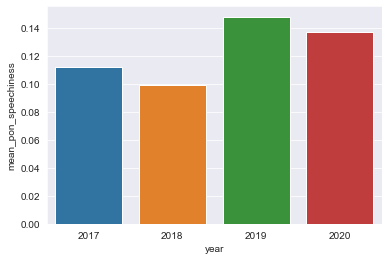

In [157]:
media_speechiness = mediapon_features ('speechiness')
sns.barplot(x="year", y="mean_pon_speechiness", data=media_speechiness)
media_speechiness

### >>> valence

,year,streamstotal_weights,mean_pon_valence
0,2017,1.0,0.628673
1,2018,1.0,0.609709
2,2019,1.0,0.612495
3,2020,1.0,0.638240


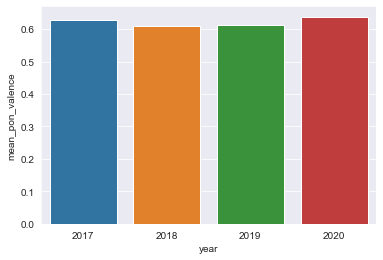

In [158]:
media_valence = mediapon_features ('valence')
sns.barplot(x="year", y="mean_pon_valence", data=media_valence)
media_valence

### >>> tempo

,year,streamstotal_weights,mean_pon_tempo
0,2017,1.0,0.352080
1,2018,1.0,0.392161
2,2019,1.0,0.382988
3,2020,1.0,0.399164


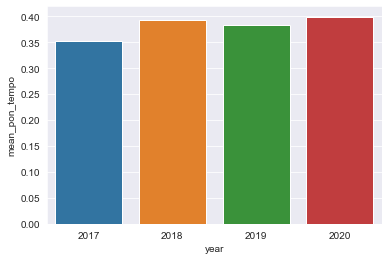

In [159]:
media_tempo = mediapon_features ('tempo')
sns.barplot(x="year", y="mean_pon_tempo", data=media_tempo)
media_tempo

### ¿Hay correlación entre la popularidad del artista y los streams?

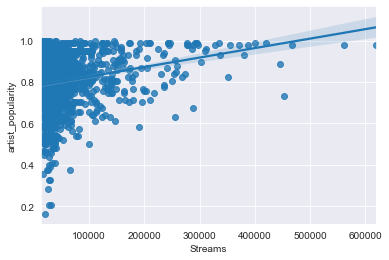

In [160]:
# Correlaciones
#sns.relplot(x="artist_popularity", y="Streamstotal", data=data_ana)
sns.regplot(x="Streams", y="artist_popularity", data=data_ana);

### ¿Hay correlación entre la popularidad de la canción y los streams?

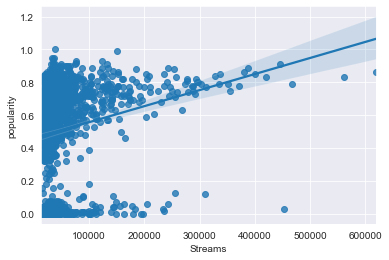

In [161]:
sns.regplot(x="Streams", y="popularity", data=data_ana);

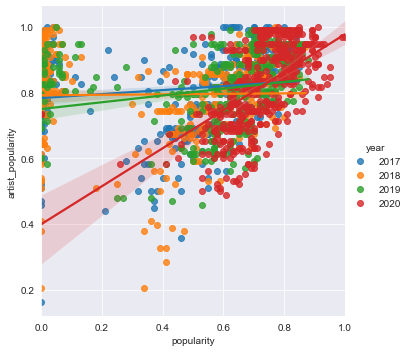

In [162]:
sns.lmplot(x="popularity", y="artist_popularity", hue="year", data=data_ana)

## Genre analisys

In [163]:
data_ana[data_ana['genre2'] =='latin'].head(50)

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights
10327,Coronao Now (Remix),El Alfa,82448,2020-03-14,047WmwIeerHyIUstFAEz5A,2020,3060737,Coronao Now (Remix),2020-02-12,0.451159,0.71,0.25500,0.883,0.853,0.000723,0.4120,0.862410,0.209612,0.695,0.371194,4,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1086173,0.846939,0.002726
10375,4K,El Alfa,48582,2020-03-14,4xI3U4sDj1TPmO9Iz5TkYp,2020,4491002,4K,2020-03-12,0.326357,0.79,0.35700,0.925,0.900,0.005950,0.1240,0.875936,0.174870,0.804,0.384744,4,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1086173,0.846939,0.003999
10436,Coronao Now,El Alfa,46740,2020-03-14,7FbKipScVxkjQxQXwTd0gL,2020,400264,Coronao Now,2019-11-07,0.368363,0.70,0.14600,0.941,0.729,0.004510,0.1800,0.770913,0.322525,0.718,0.371348,4,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1086173,0.846939,0.000356
11058,Te Quemaste,Manuel Turizo,72713,2020-03-14,4fj7e6Tc48Bmomwyz2Z2XC,2020,2841727,ADN,2019-08-23,0.320177,0.74,0.61100,0.729,0.773,0.001060,0.2870,0.937492,0.156051,0.718,0.759045,4,colombian pop,latin,latin pop,reggaeton,reggaeton colombiano,tropical,NaN,NaN,NaN,NaN,"colombian pop,latin,latin pop,reggaeton,reggae...",0tmwSHipWxN12fsoLcFU3B,5881079,0.867347,0.002531
11119,Quiéreme Mientras Se Pueda,Manuel Turizo,43423,2020-05-05,34LI7rwi9H8w2S5KTHnv1M,2020,373548,Quiéreme Mientras Se Pueda,2020-05-01,0.301855,0.84,0.44700,0.793,0.782,0.000000,0.1240,0.889593,0.050666,0.810,0.543953,4,colombian pop,latin,latin pop,reggaeton,reggaeton colombiano,tropical,NaN,NaN,NaN,NaN,"colombian pop,latin,latin pop,reggaeton,reggae...",0tmwSHipWxN12fsoLcFU3B,5881079,0.867347,0.000333
11128,Esclavo de Tus Besos,Manuel Turizo,173182,2019-03-14,3g4UyIcQwutiG0TfW32GnX,2019,9188408,Esclavo de Tus Besos,2019-02-15,0.372006,0.69,0.11300,0.805,0.671,0.000000,0.2780,0.844583,0.127099,0.522,0.190638,4,colombian pop,latin,latin pop,reggaeton,reggaeton colombiano,tropical,NaN,NaN,NaN,NaN,"colombian pop,latin,latin pop,reggaeton,reggae...",0tmwSHipWxN12fsoLcFU3B,5881079,0.867347,0.009858
11189,Sola,Manuel Turizo,49703,2019-03-14,675w3ACw5xZR3ODhUJlEVN,2019,2606780,Sola,2018-11-09,0.309802,0.58,0.48300,0.704,0.706,0.000000,0.0965,0.847308,0.127099,0.856,0.203907,4,colombian pop,latin,latin pop,reggaeton,reggaeton colombiano,tropical,NaN,NaN,NaN,NaN,"colombian pop,latin,latin pop,reggaeton,reggae...",0tmwSHipWxN12fsoLcFU3B,5881079,0.867347,0.002797
11250,Esperándote,Manuel Turizo,92181,2018-03-14,1nfyE13arjOuO54HH0zmqj,2018,6070852,Esperándote,2017-12-07,0.322031,0.65,0.42500,0.697,0.648,0.000000,0.1910,0.785259,0.151708,0.313,0.826339,4,colombian pop,latin,latin pop,reggaeton,reggaeton colombiano,tropical,NaN,NaN,NaN,NaN,"colombian pop,latin,latin pop,reggaeton,reggae...",0tmwSHipWxN12fsoLcFU3B,5881079,0.867347,0.008635
11311,Una Lady Como Tú,Manuel Turizo,31895,2018-03-14,7MHN1aCFtLXjownGhvEQlF,2018,1658028,Una Lady Como Tú,2017-04-10,0.355913,0.72,0.54900,0.788,0.477,0.000000,0.3490,0.777873,0.029241,0.860,0.217390,4,colombian pop,latin,latin pop,reggaeton,reggaeton colombiano,tropical,NaN,NaN,NaN,NaN,"colombian pop,latin,latin pop,reggaeton,reggae...",0tmwSHipWxN12fsoLcFU3B,5881079,0.867347,0.002358
11372,Una Lady Como Tú (feat. Nicky Jam) - Remix,Manuel Turizo,26139,2018-03-14,7MMRoGvm7uhoUVhGvHJ3yW,2018,82768,Una Lady Como Tú (feat. Nicky Jam) [Remix],2017-08-04,0.395542,0.59,0.39200,0.518,0.532,0.000000,0.3550,0.776100,0.078025,0.741,0.217557,4,colombian pop,lati

In [164]:
data_ana.Artist.value_counts()

Bad Bunny           44
J Balvin            31
Ozuna               28
C. Tangana          25
Ed Sheeran          22
                    ..
La Nueva Escuela     1
MÉLOVIN              1
Rosana               1
Vetusta Morla        1
KvndySwing           1
Name: Artist, Length: 474, dtype: int64

In [165]:
number_genres = data_ana.genre1.value_counts()
number_genres.head(60)

latin                        379
dance pop                    199
colombian pop                 83
latin pop                     68
pop                           58
trap espanol                  56
spanish pop                   54
cantautor                     48
latin arena pop               34
big room                      31
r&b en espanol                28
canadian contemporary r&b     22
argentine hip hop             21
latin viral pop               20
electropop                    20
canadian hip hop              19
flamenco urbano               18
eurovision                    17
rap espanol                   17
dominican pop                 16
modern rock                   15
dfw rap                       13
boy band                      12
conscious hip hop             12
champeta                      11
canadian pop                  11
panamanian pop                11
garage rock                   11
trap latino                   10
emo rap                        9
dembow    

In [350]:
# Para depurar el genre, los que el genre1 sea latin, se les asignará el valor en genre2, que es más específico
# y los que el genre1 no sea latin se les asignara ese genre1
data_ana_nolatinfirst = data_ana[data_ana['genre1'] != 'latin']
data_ana_latinfirst = data_ana[data_ana['genre1'] == 'latin']

data_ana.loc[data_ana.genre1 == 'latin', 'genre_final'] = data_ana_latinfirst['genre2']
data_ana.loc[data_ana.genre2 == 'latin pop', 'genre_final'] = data_ana_latinfirst['genre3']
data_ana.loc[data_ana.genre1 != 'latin', 'genre_final'] = data_ana_nolatinfirst['genre1']



In [351]:
number_genres_new = data_ana.genre_final.value_counts()
number_genres_new.head(60)

dance pop                    199
reggaeton                    148
latin hip hop                 89
colombian pop                 83
latin arena pop               75
latin pop                     68
spanish pop                   59
pop                           58
trap espanol                  56
cantautor                     48
puerto rican pop              47
r&b en espanol                41
big room                      31
latin viral pop               22
canadian contemporary r&b     22
argentine hip hop             21
electropop                    20
canadian hip hop              19
flamenco urbano               18
reggaeton flow                18
rap espanol                   17
eurovision                    17
dominican pop                 16
modern rock                   15
dfw rap                       13
boy band                      12
conscious hip hop             12
garage rock                   11
champeta                      11
canadian pop                  11
panamanian

In [352]:
#Tras un análisis por géneros, es complicado, porque el primer género listado no distingue bien
# Si encuentra latin, pasa a la siguiente columna y busca por los otros términos y así sicesivamente

list_genres_pop = 'k-pop, pop, boy band, eurovision'
list_genres_dancepop = 'dance, tropical, edm, electropop, big room'
list_genres_rock = 'rock, indie'
reggaeton = 'dembow, reggaeton, champeta'
list_genres_rap = 'hip hop, rap, funk, trap, r&b'
cantautor = 'cantautor, flamenco'

'''
list_genres_pop = ['k-pop', 'pop', 'boy band', 'eurovision']
list_genres_dancepop = ['dance', 'tropical', 'edm', 'electropop', 'big room']
list_genres_rock = ['rock', 'indie']
reggaeton = ['dembow', 'reggaeton', 'champeta']
list_genres_rap = ['hip hop', 'rap', 'funk', 'trap', 'r&b']
cantautor = ['cantautor','flamenco']'''


"\nlist_genres_pop = ['k-pop', 'pop', 'boy band', 'eurovision']\nlist_genres_dancepop = ['dance', 'tropical', 'edm', 'electropop', 'big room']\nlist_genres_rock = ['rock', 'indie']\nreggaeton = ['dembow', 'reggaeton', 'champeta']\nlist_genres_rap = ['hip hop', 'rap', 'funk', 'trap', 'r&b']\ncantautor = ['cantautor','flamenco']"

In [353]:
data_ana['genre_depurated'] = pd.np.where(data_ana.genre_final.str.contains("dance"), 'dance, tropical, edm, electropop, big room',
                              pd.np.where(data_ana.genre_final.str.contains("tropical"), 'dance, tropical, edm, electropop, big room',            
                              pd.np.where(data_ana.genre_final.str.contains("edm"), 'dance, tropical, edm, electropop, big room',
                              pd.np.where(data_ana.genre_final.str.contains("electropop"), 'dance, tropical, edm, electropop, big room',
                              pd.np.where(data_ana.genre_final.str.contains("big room"), 'dance, tropical, edm, electropop, big room',
                                          
                              pd.np.where(data_ana.genre_final.str.contains("pop"), 'pop, k-pop, boy band, eurovision, carnaval',
                              pd.np.where(data_ana.genre_final.str.contains("k-pop"), 'pop, k-pop, boy band, eurovision, carnaval',
                              pd.np.where(data_ana.genre_final.str.contains("carnaval"), 'pop, k-pop, boy band, eurovision, carnaval',                      
                              pd.np.where(data_ana.genre_final.str.contains("eurovision"), 'pop, k-pop, boy band, eurovision, carnaval',
                              pd.np.where(data_ana.genre_final.str.contains("boy band"), 'pop, k-pop, boy band, eurovision, carnaval',
                        
                              pd.np.where(data_ana.genre_final.str.contains("rock"), 'rock, indie',            
                              pd.np.where(data_ana.genre_final.str.contains("indie"), 'rock, indie',
                                          
                              pd.np.where(data_ana.genre_final.str.contains("bachata"), 'dembow, reggaeton, champeta, cubaton',                               
                              pd.np.where(data_ana.genre_final.str.contains("dembow"), 'dembow, reggaeton, champeta, cubaton',            
                              pd.np.where(data_ana.genre_final.str.contains("reggaeton"), 'dembow, reggaeton, champeta, cubaton',            
                              pd.np.where(data_ana.genre_final.str.contains("champeta"), 'dembow, reggaeton, champeta, cubaton',
                              pd.np.where(data_ana.genre_final.str.contains("cubaton"), 'dembow, reggaeton, champeta, cubaton',
                                          
                              pd.np.where(data_ana.genre_final.str.contains("hip hop"), "rap, hip hop, funk, trap, r&b",            
                              pd.np.where(data_ana.genre_final.str.contains("rap"), "rap, hip hop, funk, trap, r&b",            
                              pd.np.where(data_ana.genre_final.str.contains("funk"), "rap, hip hop, funk, trap, r&b",            
                              pd.np.where(data_ana.genre_final.str.contains("trap"), "rap, hip hop, funk, trap, r&b",            
                              pd.np.where(data_ana.genre_final.str.contains("r&b"), "rap, hip hop, funk, trap, r&b",
                                          
                              pd.np.where(data_ana.genre_final.str.contains("cantautor"), 'cantautor, flamenco',            
                              pd.np.where(data_ana.genre_final.str.contains("flamenco"), 'cantautor, flamenco',            
                                    
                                          "other"))))))))))))))))))))))))
data_ana[data_ana['genre_final'] == 'dembow']

<ipython-input-353-88a1b1355dec>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  data_ana['genre_depurated'] = pd.np.where(data_ana.genre_final.str.contains("dance"), 'dance, tropical, edm, electropop, big room',
<ipython-input-353-88a1b1355dec>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(data_ana.genre_final.str.contains("tropical"), 'dance, tropical, edm, electropop, big room',
<ipython-input-353-88a1b1355dec>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(data_ana.genre_final.str.contains("edm"), 'dance, tropical, edm, electropop, big room',
<ipython-input-353-88a1b1355dec>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import nump

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights,genre_final,genre_depurated
10327,Coronao Now (Remix),El Alfa,82448,2020-03-14,047WmwIeerHyIUstFAEz5A,2020,3060737,Coronao Now (Remix),2020-02-12,0.451159,0.71,0.255,0.883,0.853,0.000723,0.4120,0.862410,0.209612,0.695,0.371194,4,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1086173,0.846939,0.002726,dembow,"dembow, reggaeton, champeta, cubaton"
10375,4K,El Alfa,48582,2020-03-14,4xI3U4sDj1TPmO9Iz5TkYp,2020,4491002,4K,2020-03-12,0.326357,0.79,0.357,0.925,0.900,0.005950,0.1240,0.875936,0.174870,0.804,0.384744,4,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1086173,0.846939,0.003999,dembow,"dembow, reggaeton, champeta, cubaton"
10436,Coronao Now,El Alfa,46740,2020-03-14,7FbKipScVxkjQxQXwTd0gL,2020,400264,Coronao Now,2019-11-07,0.368363,0.70,0.146,0.941,0.729,0.004510,0.1800,0.770913,0.322525,0.718,0.371348,4,dembow,latin,rap dominicano,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,"dembow,latin,rap dominicano,reggaeton,tropical",2oQX8QiMXOyuqbcZEFsZfm,1086173,0.846939,0.000356,dembow,"dembow, reggaeton, champeta, cubaton"
11375,Rueda,Chimbala,70216,2020-03-14,4NDHYPVJ5zLnR8yYZsMDsu,2020,3871511,Rueda,2019-07-19,0.349507,0.68,0.165,0.888,0.916,0.000004,0.0519,0.947012,0.099884,0.960,0.451617,4,dembow,dominican pop,latin,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,latin,rap dominicano",4VVEpEhC8NcR7AqNEds42U,205320,0.704082,0.003448,dembow,"dembow, reggaeton, champeta, cubaton"
11436,Rueda - Remix,Chimbala,72331,2020-03-20,3EWxpqOSP0KWgUmRiklqGy,2020,5466191,Rueda (Remix),2020-03-19,0.354069,0.72,0.256,0.864,0.925,0.000009,0.0648,0.957420,0.072669,0.961,0.451744,4,dembow,dominican pop,latin,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,latin,rap dominicano",4VVEpEhC8NcR7AqNEds42U,205320,0.704082,0.004868,dembow,"dembow, reggaeton, champeta, cubaton"
16382,La Rubia - Remix 2,La Nueva Escuela,61243,2020-03-14,7KKTnv81z6DmfPIGsZWjOW,2020,3253091,La Rubia,2019-04-19,0.350359,0.68,0.319,0.758,0.717,0.000006,0.3780,0.881418,0.156051,0.753,0.316969,4,dembow,dominican pop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop",7mcJN2bWqCv7jvykgHp4KN,64412,0.581633,0.002897,dembow,"dembow, reggaeton, champeta, cubaton"
26980,Ellos,Ceky Viciny,34777,2020-03-17,7bDboJVS7UlQBZj8lsvz2g,2020,1262764,Ellos,2019-07-05,0.258610,0.45,0.124,0.754,0.939,0.002810,0.2930,0.954990,0.022438,0.853,0.397939,4,dembow,dominican pop,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,rap dominicano",5UopXhshFFqRIMfeZrBclq,62120,0.602041,0.001125,dembow,"dembow, reggaeton, champeta, cubaton"
27016,Ellos,Ceky Viciny,31018,2019-04-18,1tDUwlIyFFcmfMypYoQ4Ns,2019,2039392,Ellos,2019-03-11,0.258610,0.00,0.124,0.754,0.939,0.002810,0.2930,0.954990,0.022438,0.853,0.397939,4,dembow,dominican pop,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,rap dominicano",5UopXhshFFqRIMfeZrBclq,62120,0.602041,0.002188,dembow,"dembow, reggaeton, champeta, cubaton"
35549,Mujeres,Mozart La Para,46228,2019-03-14,6xLvYhLOW2oETJoZv8ChU8,2019,1836540,Mujeres,2018-06-08,0.290882,0.60,0.204,0.835,0.767,0.000079,0.2610,0.832009,0.065721,0.710,0.250723,4,dembow,dominican pop,rap dominicano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"dembow,dominican pop,rap dominicano",0odliLZMTk45CEVzF3Zocl,254471,0.704082,0.001970,dembow,"dembow, reggaeton, champeta, cubaton"


In [356]:
number_genres2 = data_ana.genre_depurated.value_counts()
number_genres2.head(60)

pop, k-pop, boy band, eurovision, carnaval    549
rap, hip hop, funk, trap, r&b                 371
dance, tropical, edm, electropop, big room    288
dembow, reggaeton, champeta, cubaton          207
other                                          69
cantautor, flamenco                            66
rock, indie                                    40
Name: genre_depurated, dtype: int64

In [357]:
#Total reproducciones 
data_group = data_ana.groupby(['genre_depurated']).agg(['sum', 'count'])
data_group['year']
#Falta hacerlo por ponderación con reproducciones

,sum,count
genre_depurated,,
"cantautor, flamenco",133244,66
"dance, tropical, edm, electropop, big room",581235,288
"dembow, reggaeton, champeta, cubaton",417920,207
other,139260,69
"pop, k-pop, boy band, eurovision, carnaval",1108139,549
"rap, hip hop, funk, trap, r&b",748926,371
"rock, indie",80717,40


In [358]:
data_group = data_ana.groupby(['genre_depurated', 'year']).agg(['sum', 'count'])
data_group['Streamstotal']

sum  count
genre_depurated                            year                  
cantautor, flamenco                        2017    4965927     10
                                           2018    5919745     14
                                           2019   12525477     18
                                           2020   50389798     24
dance, tropical, edm, electropop, big room 2017  132809971     96
                                           2018  136905217     87
                                           2019  139193857     63
                                           2020   83195815     42
dembow, reggaeton, champeta, cubaton       2017   54618153     35
                                           2018  101564360     32
                                           2019  174078079     51
                                           2020  357994068     89
other                                      2017   26943182     24
                                           2018   14232220     16
                                           2019   34998522     16
                                           2020   15840893     13
pop, k-pop, boy band, eurovision, carnaval 2017  129006885    135
                                           2018  272721104    146
                                           2019  330379405    144
                                           2020  358853083    124
rap, hip hop, funk, trap, r&b              2017   69310311     71
                                           2018  167986066    103
                                           2019  235996187     75
                                           2020  251849789    122
rock, indie                                2017    6816686     16
                                           2018    3703775     14
                                           2019    4888875      7
                                           2020    4802067      3

In [359]:
data_group2 = data_ana.groupby(['genre1', 'year']).agg(['sum', 'count'])
data_group2['Streamstotal'].sort_values(by='count', ascending=False)

sum  count
genre1             year                  
latin              2020  464786598    120
                   2019  363379181     99
                   2018  287024324     83
                   2017  112415135     77
dance pop          2017  104103680     75
...                            ...    ...
danish pop         2019    2436163      1
dancehall          2017    5700710      1
czech pop          2018     221520      1
cumbia             2018    1539931      1
venezuelan hip hop 2020     672612      1

[246 rows x 2 columns]

In [360]:
data_ana[data_ana['genre_depurated'] == 'dembow, reggaeton, champeta, cubaton']

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,genres_together,artist_id,artist_followers,artist_popularity,streamstotal_weights,genre_final,genre_depurated
0,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,2019-11-07,0.324972,0.91,0.29500,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.016786,reggaeton,"dembow, reggaeton, champeta, cubaton"
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,7027186,Follow,2020-04-01,0.330442,0.78,0.66700,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.006258,reggaeton,"dembow, reggaeton, champeta, cubaton"
103,Créeme,KAROL G,72543,2019-03-14,1mT47pKLXUwPYGwB91GcNz,2019,3197262,Créeme,2018-11-02,0.354546,0.72,0.15400,0.715,0.872,0.000146,0.1100,0.904169,0.045599,0.682,0.230459,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.003430,reggaeton,"dembow, reggaeton, champeta, cubaton"
153,Culpables,KAROL G,56296,2019-03-14,6q8Lb50EtqNeeJXXe8mMAH,2019,2080234,Culpables,2018-09-14,0.390787,0.69,0.27900,0.728,0.801,0.000005,0.1430,0.922521,0.065287,0.416,0.451744,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.002232,reggaeton,"dembow, reggaeton, champeta, cubaton"
203,Punto G,KAROL G,51826,2019-04-05,5Lb1pjnll07UQKxNpnnGBy,2019,1930173,Punto G,2019-04-05,0.275291,0.61,0.00796,0.787,0.751,0.000139,0.0857,0.863559,0.091633,0.926,0.691617,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,"latin,latin pop,reggaeton,reggaeton colombiano",790FomKkXshlbRYZFtlgla,11337789,0.887755,0.002071,reggaeton,"dembow, reggaeton, champeta, cubaton"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46155,Bailame Despacio,Xantos,79678,2017-03-14,4OaTpLJIa2harufGxfOPUu,2017,5050041,Revolucionario,2015-10-21,0.425083,0.55,0.16300,0.688,0.719,0.000000,0.1500,0.863296,0.046757,0.605,0.170835,4,reggaeton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reggaeton,3HPOnbuwLP2qlwWQ7cgxYW,167636,0.540816,0.011897,reggaeton,"dembow, reggaeton, champeta, cubaton"
46297,"Ay Mi Dios (feat. Pitbull, Yandel & Chacal)",IAmChino,66219,2017-03-14,6stYbAJgTszHAHZMPxWWCY,2017,5211785,"Ay Mi Dios (feat. Pitbull, Yandel & Chacal)",2016-02-22,0.455862,0.00,0.16700,0.761,0.829,0.000000,0.1890,0.913953,0.064997,0.813,0.197680,4,cubaton,reggaeton,tropical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"cubaton,reggaeton,tropical",0b2GL7Y02vu50qieoQmw1w,43986,0.591837,0.012278,cubaton,"dembow, reggaeton, champeta, cubaton"
46358,Hasta Que Se Seque el Malecón (feat. Farruko) ...,Jacob Forever,59790,2017-03-14,6sMPwcpYtxm1mlgYbp1B0t,2017,1817657,Invicto,2017-02-06,0.362136,0.60,0.36200,0.785,0.838,0.000006,0.1390,0.823736,0.021569,0.765,0.251351,4,cubaton,tropical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"cubaton,tropical",4fCRFHEQgjqakvFgQCliMp,128729,0.612245,0.004282,cubaton,"dembow, reggaeton, champeta, cubaton"
46419,Quiéreme,Jacob Forever,22337,2017-04-01,649tz8MtbCHSTEzNBw7c1Q,2017,504153,Invicto,2017-02-06,0.300934,0.49,0.44300,0.703,0.663,0.000062,0.0982,0.851609,0.067458,0.384,0.758591,4,cubaton,tropical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"cubaton,tropical",4fCRFHEQgjqakvFgQCliMp,128729,0.612245,0.001188,cubaton,"d